![QE](https://avatars3.githubusercontent.com/u/8703060?v=3&s=400)

# Finite Markov Chains

This script follows the Markov chapter in the QuantEcon book.  We start by defining a Markov (or stochastic) matrix as one that contains only positive numbers, with rows that sum to one.  So, each row is a like a PDF.  Let is construct such a matrix.  We could assign these probabilities directly, but in the spirit of executing a pedaogogical exercise, let us envision we are drawing 5 samples of 100 from an infinite population of colored balls (in an urn, of course).  Each of the balls are one of the following colors: blue, red, green, yellow, or orange.  The proportions of each color in each sample will serve as the probabilities we will use to fill out our stochastic matrix.

In [1]:
using StatsBase
using Gadfly
using QuantEcon

set_default_plot_size(20cm, 15cm)

In [2]:
#Define color set
colors=["blue","red","green","yellow","orange"]

#Draw five samples from an 'infinite' population of colors
##Generate container for sample PDFs
pdfs=Array[]
##For each of five samples...
for i in 1:5
  ##...generate a temporary list...
  tmp_smpl=String[]
  ##...and draw 100 colors randomly...
  for i in 1:100
    push!(tmp_smpl,colors[rand(1:length(colors))])
  end
  ##...then collect the proportions of each color in the sample
  println(proportionmap(tmp_smpl))
  push!(pdfs,collect(values(proportionmap(tmp_smpl))))
end

#Convert list of arrays into a stochastic matrix
stoch_mat=[arr[i] for arr in pdfs, i in 1:5]

#Confirm the rows sum to one
all_one=all([val==1 for val in sum(stoch_mat,2)])
println("All rows sum to one: $all_one")

stoch_mat

["yellow"=>0.21,"orange"=>0.23,"blue"=>0.18,"green"=>0.15,"red"=>0.23]
["yellow"=>0.18,"orange"=>0.29,"blue"=>0.19,"green"=>0.16,"red"=>0.18]
["yellow"=>0.16,"orange"=>0.15,"blue"=>0.17,"green"=>0.19,"red"=>0.33]
["yellow"=>0.21,"orange"=>0.2,"blue"=>0.23,"green"=>0.19,"red"=>0.17]
["yellow"=>0.19,"orange"=>0.18,"blue"=>0.2,"green"=>0.25,"red"=>0.18]
All rows sum to one: true


5x5 Array{Any,2}:
 0.21  0.23  0.18  0.15  0.23
 0.18  0.29  0.19  0.16  0.18
 0.16  0.15  0.17  0.19  0.33
 0.21  0.2   0.23  0.19  0.17
 0.19  0.18  0.2   0.25  0.18

So, what does this matrix mean?  It captures the probabilities associated with state transitions.  `stoch_mat[i,j]` captures the probability of being in state $j$ at time $t+1$ given being in state $i$ at time $t$.  For example, if we started in state 2 (that is, in the second row), the probability of moving to state 4 (the fourth column) is 0.16 (`stoch_mat[2,4]`). The complete set of all possible probabilities for the states at time $t+1$ are given in the row occupied at time $t$.  One application for this would be exploring the probability of employment vs unemployment.

Suppose we had two transition probabilities between employment and unemployment:

+ Probability of moving from employed (E) to unemployed (U) in period $t$: $\beta \in (0,1)$
+ Probability of moving from unemployed (U) to employed (E) in period $t$: $\alpha \in (0,1)$

This would leave us with the following transition (Markov) matrix:

$P = \left( \begin{matrix} 1-\alpha & \alpha \\ \beta & 1-\beta \end{matrix} \right)$

Markov processes can be explored through simulation.  For example, if we wanted to know the probability of employment, we can simulate many times and count the fraction of times in which it occurs.  To simulate a Markov chain, we need the stochastic matrix ($P$) and the distribution of the initial state ($\psi$).  In the matrix we created above, $\psi$ is the distribution of values along the support $S$ (that is, the distribution of values within each row).  The initial state $X_0$ is drawn from this distribution.  So, there are two broad steps:

1. At $t=0$, the initial state $X_0$ is drawn from $\psi$; and,
2. At $t>0$, the new state $X_{t+1}$ is drawn from the distribution in the appropriate row, $P[X_t, \cdot]$.

To test this all out, we need some way of taking draws from a discrete random distribution.  We could just load the **`QuantEcon`** package and use their method `draw()` (which wraps the single draw method `DiscreteRV()`).  However, the method is not all that complex, and building ourselves provides a bit of a view into how objects and methods are constructed in Julia.  

Let's start with creating a discrete random draw object.  The first thing to notice is that this guy looks a whole lot like a derived type in fortran.

In [3]:
type DiscRandDraw{T<:Real}  #Have to declare the data type and it's parent "abstract" type
    #Declare attributes of object
    q :: Vector{T} #Vector of probabilities that sum to 1
    Q :: Vector{T} #Cumulative sum of q
    #Define constructor
    DiscRandDraw(x :: Vector{T}) = new(x, cumsum(x))  #Notice how both q and Q are defined with a single input vector x
end

Let's take this baby for a test run (by which I mean we will work through some "mistakes")...

In [4]:
println(stoch_mat[1,:])
DiscRandDraw(stoch_mat[1,:])

Any[0.21 0.23 0.18 0.15 0.23]


LoadError: `DiscRandDraw{T<:Real}` has no method matching DiscRandDraw{T<:Real}(::Array{Any,2})
while loading In[4], in expression starting on line 2

Hmmm, we have our row from the stochastic matrix as the test case, but apparently the type of the row is not included in the acceptable set of types available to `DiscRandDraw`.  Judging by our traceback, we have entered an array construct of type `Any` and `DiscRandDraw` is looking for type `T`.  In this case, `T` seems to capture the set of types contained within the [abstract type](http://julia.readthedocs.org/en/latest/manual/types/#abstract-types) `Real`.  The `Any` type, however, is a superset of `Real`, so if we declare it directly in the instantiation of the DiscRandDraw object, it probably won't work.

In [5]:
DiscRandDraw{Any}(stoch_mat[1,:])

LoadError: type: DiscRandDraw: in T, expected T<:Real, got Type{Any}
while loading In[5], in expression starting on line 1

Confirmed.  `Type{Any}` is not contained within the collection of types `T<:Real`.  Since we are dealing with real numbers in the stochastic matrix anyway, let's convert to float.  Just to confirm, we still need to declare the type of input for `DiscRandDraw`.  The following still does not work.

In [6]:
DiscRandDraw(float(stoch_mat[1,:]))

LoadError: `DiscRandDraw{T<:Real}` has no method matching DiscRandDraw{T<:Real}(::Array{Float64,2})
while loading In[6], in expression starting on line 1

When we correctly declare the type, something different happens.

In [7]:
DiscRandDraw{Float64}(float(stoch_mat[1,:]))

LoadError: `DiscRandDraw{Float64}` has no method matching DiscRandDraw{Float64}(::Array{Float64,2})

You might have used a 2d row vector where a 1d column vector was required.
Note the difference between 1d column vector [1,2,3] and 2d row vector [1 2 3].
You can convert to a column vector with the vec() function.
while loading In[7], in expression starting on line 1

Our row from the stochastic matrix has two dimensions!  We must convert it to a one-dimensional construct for use with `DiscRandDraw`.  That is, it must be a `Vector`, and not a 2D `Array`.  We can do this with either the `reshape()` or `vec()` methods.

In [8]:
DiscRandDraw{Float64}(float(vec(stoch_mat[1,:])))

DiscRandDraw{Float64}([0.21,0.23,0.18,0.15,0.23],[0.21,0.44,0.62,0.77,1.0])

Success!  Note, however, that the type of the input must match the type parameter used when instantiating the object.  If the object type parameter is `Int64` and we feed the [constructor](http://julia.readthedocs.org/en/latest/manual/constructors/#constructors) a vector of integers, everything is just fine.  If we instead combine a vector of floats with an object type parameter of `Int64`, julia gets confused.

In [9]:
println(DiscRandDraw{Int64}([0,1]))
DiscRandDraw{Int64}(float(vec(stoch_mat[1,:])))

DiscRandDraw{Int64}([0,1],[0,1])


LoadError: `DiscRandDraw{Int64}` has no method matching DiscRandDraw{Int64}(::Array{Float64,1})
while loading In[9], in expression starting on line 2

The reason that this occurs is because of how julia engages in something called [multiple dispatch](https://en.wikipedia.org/wiki/Multiple_dispatch).  There is a lot to this concept, but in a nutshell, object definitions actually capture a whole collection of objects.  In our case, when we created `DiscRandDraw`, we specified the input data type to be all of the types included in the abstract type `Real` (`T<:Real`).  We didn't create one object, but rather one object for each data type in the set.  When we call `DiscRandDraw{Int64}`, julia focuses on only the object version associated with integers.  When we feed it floats, and it searches through the available input data types (of which there is only one, integer), it says it can't find a method matching the data type.

Now, what if we didn't want to have to declare the type of input every time we wanted to instantiate a new `DiscRandDraw` object?  We can get around this by using what is called an [outside constructor](http://julia.readthedocs.org/en/latest/manual/constructors/#outer-constructor-methods).  (By contrast, the constructor used within the type definition is known as an [inside constructor](http://julia.readthedocs.org/en/latest/manual/constructors/#inner-constructor-methods).)  They use the following general form:

`new constructor = old constructor with given inputs`

For example, suppose we had the following [type](http://julia.readthedocs.org/en/latest/manual/constructors/#constructors):

    type Foo
        bar
        baz
    end
    
We could instantiate an new instance:  `foo = Foo (1,2)`.  Note how it requires two inputs for a valid instance.  If we wanted a constructor that allowed us to feed in one input value, which would then be copied to both input positions, we could build a new constructor:  `Foo(x) = Foo(x,x)`.  

In our case, we just want the `DiscRandDraw` constructor to recognize the type of input given.  The type requires an input of a type contained within the abstract type `Real` (`T` is just a type variable).  The following constructor ensures that as long as this test is met, no further information is required.

In [10]:
DiscRandDraw{T<:Real}(x::Vector{T})=DiscRandDraw{T}(x)

DiscRandDraw{T<:Real} (constructor with 1 method)

My interpretation is that it queries the type of input, and then uses this input as a parameter in the `DiscRandDraw` constructor.  As can be seen below...

In [11]:
println(DiscRandDraw([0,1]))
println(DiscRandDraw(float(vec(stoch_mat[1,:]))))

DiscRandDraw{Int64}([0,1],[0,1])
DiscRandDraw{Float64}([0.21,0.23,0.18,0.15,0.23],[0.21,0.44,0.62,0.77,1.0])


...it works.  

Great job guy, you created an object that holds a couple vectors.  Perhaps we could do something interesting with it?  In this case, it would be awesome to have a method that chose from the available support values (`range(1,5)`) based upon the weights or probabilities contained within the `DiscRandDraw` object (`[0.2,0.12,0.29,0.19,0.2]`).  Conceptually, we might think of this as a random draw from the classic urn with colored balls.  Out of a population of size $N$ the proportion of total balls allocated to each color is given:  `["yellow"=>0.2,"orange"=>0.12,"blue"=>0.29,"green"=>0.19,"red"=>0.2]`.  If these proportions are to be trusted, and the probability of selecting any given ball is uniform, then the probability of selecting a given color will correspond with it's proportional representation.

How can we use this in the current context?  Let's reconceptualize our urn filled with balls as the collection of values on the (0,1) interval.  The number of balls for each color is recast as the proportions of space on the number line.  For example, instead of 20% of the balls being yellow, 20% of the (0,1) interval (e.g. `range(0,0.2)`) is the yellow *region*.  The random selection of a ball is instead a draw from the uniform distribution within the (0,1) interval.  Since no particular value in the interval is more likely to be chosen than another, it does not matter if the yellow region is contiguous or not, so long as it covers 20% of the interval space.  The probability of a given color being chosen is a function of only the size of the region assigned to it, and nothing else.

With this recasting, we can just take a random draw and see where it falls in the cumulative distribution.  The color selected is that which is associated with the region in which the random number lies.  As an operational matter, the probabilities provided in the vector fed into `DiscRandDraw` are simultaneously the upper limits for the range of each color.  So, color selection is based upon the first probability that exceeds the random draw.  For example, a draw of `0.33` is greater than `0.32`, but less than `0.61`, so the color selected is `blue` (which lies on the interval `(0.32,0.61]`).  Luckily, there is an intrinsic function in julia that returns the index of the first value in a sequence to exceed a given value

In [12]:
?searchsortedfirst

INFO: Loading help data...


Base.searchsortedfirst(a, x, [by=<transform>,] [lt=<comparison>,] [rev=false])

   Returns the index of the first value in "a" greater than or equal
   to "x", according to the specified order. Returns "length(a)+1"
   if "x" is greater than all values in "a".


We can use this to generate our random draw function.

In [13]:
draw(d::DiscRandDraw)=searchsortedfirst(d.Q,rand()) #Note how we can access object parameters through dot notation

draw (generic function with 1 method)

Does it work?

In [14]:
#Reorder colors to match probability mapping
col_map=["yellow","orange","blue","green","red"]

#Take random draw from range
drd=DiscRandDraw(float(vec(stoch_mat[1,:])))

col_map[draw(drd)]

"red"

Cool.  Now we want to extend this method so that it can handle multiple draws.  This is easy enough with a comprehension, but note the input array must be typed.

In [15]:
draw(d::DiscRandDraw,k::Int) = Int[draw(d) for i=1:k]

[col_map[val] for val in draw(drd,5)]

5-element Array{Any,1}:
 "blue"  
 "red"   
 "orange"
 "orange"
 "green" 

So ends the digression into object and method construction.

## Constructing Time Series

Now that we have a method of generating random draws, we can simulate transitions between states in a stochastic matrix $P$.  How might we use this to generate a time series?  To precise, we want to generate a data series that spans $n$ time periods.  The data generating process underlying the series exhibits stochastic serial dependence.  Given a value at a given time, $X_t$, the value in the next period, $X_{t+1}$ will be a function of probability distribution function conditional on the value of $X_t$.  The function should be able to generate this time series from three inputs:

1. The transition (or stochastic) matrix $P$ (`P`);
2. An initial state or a probability distribution function from which to draw an initial state (`init`);
3. An integer capturing the number of data points, $n$, to be simulated (`sample_size`).

Drs. Sargent and Stachurski have already provided a function to do this as part of the **`QuantEcon`** package, but let's wedge in a little more practice and build one ourselves.  We can test it on our existing matrix `stoch_mat`.  This is purely a pedagogical exercise and will not include separate types for transition matrices and attendant verification checks.  Once we have defined the bare bones, we can use their more developed version.

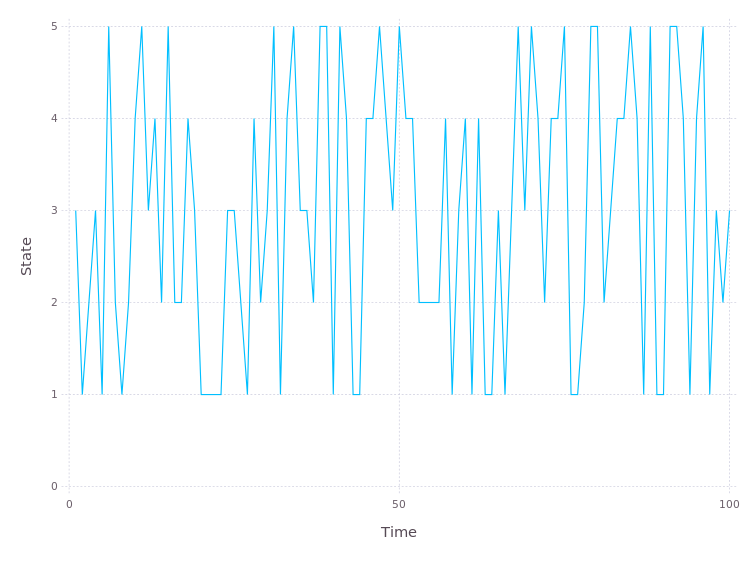

In [16]:
function sim_data(mat::Array,init::Int64,sample_size::Int64)
    #Initialize data series
    data=Int64[init]
    #Capture initial value in updateable variable
    x=init
    #For each of the remaining time periods...
    for t=2:sample_size
        #...define a state-specific discrete random draw object...
        drd_obj=DiscRandDraw(float(vec(stoch_mat[x,:])))
        #...take a random draw given the current state...
        new_x=draw(drd_obj)
        #...capture the new value...
        push!(data,new_x)
        #...update the value variable
        x=new_x
    end
    return data
end

#Simulate time series
periods=1:100
data=sim_data(stoch_mat,3,length(periods))
    
#Plot data
plot(x=periods,y=data,Geom.line,Guide.xlabel("Time"),Guide.ylabel("State"))

Now let's generate a similar plot using **`QuantEcon's`** method, `mc_sample_path()`.  Note that the method does not accept arrays, but rather `MarkovChain` objects (which themselves accept only arrays of floats).  This is an example of poor inline documentation.  I wouldn't have known without looking at the source.

In [17]:
?mc_sample_path

mc_sample_path (generic function with 7 methods)


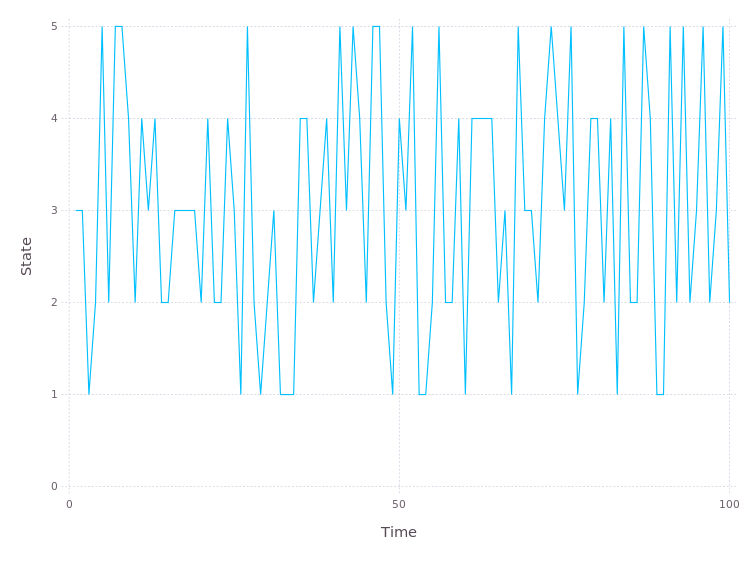

In [18]:
#Simulate time series
periods=1:100
data=mc_sample_path(MarkovChain(float(stoch_mat)),3,length(periods))

#Plot data
plot(x=periods,y=data,Geom.line,Guide.xlabel("Time"),Guide.ylabel("State"))

## Marginal Distributions

In [19]:
P_raw

LoadError: P_raw not defined
while loading In[19], in expression starting on line 1

In [20]:
stoch_mat

5x5 Array{Any,2}:
 0.21  0.23  0.18  0.15  0.23
 0.18  0.29  0.19  0.16  0.18
 0.16  0.15  0.17  0.19  0.33
 0.21  0.2   0.23  0.19  0.17
 0.19  0.18  0.2   0.25  0.18